# Michał Filipiuk - 385423
## SAD assignment

### Imports

In [114]:
library(car)
library(caret)
library(purrr)
library(tidyr)
library(ggplot2)
library(reshape)
library(MASS)
library(Metrics)
library(lightgbm)
library(glmnet)
library(xgboost)


Attaching package: ‘xgboost’

The following objects are masked from ‘package:lightgbm’:

    getinfo, setinfo, slice



### Loading data

#### Cancer data - regression

In [2]:
load("cancer.RData")
cancer.data.train <- data.train
cancer.data.test <- data.test

#### Protein - regression

In [17]:
load("protein.RData")
protein.data.train <- data.frame(data.train)
protein.data.test <- data.test

### Data preprocessing

To analyze which columns are categorical and which are numerical, I will count the percent of unique values for each variable. If number is smaller than 1%, I'll classify it as categorical.

Cancer

In [4]:
cancer.categorical.columns <- colnames(cancer.data.train)[sapply(cancer.data.train, function(x){return(length(unique(x))/nrow(cancer.data.train)*100 < 1)})]

In [5]:
length(cancer.categorical.columns) / ncol(cancer.data.train)

[1] 0

Protein

In [18]:
protein.categorical.columns <- colnames(protein.data.train)[sapply(protein.data.train, function(x){return(length(unique(x))/nrow(protein.data.train)*100 < 1)})]

In [19]:
protein.data.train[protein.categorical.columns]  <- lapply(protein.data.train[protein.categorical.columns] , factor)

In [8]:
for(c in protein.categorical.columns){
    levels(protein.data.train[,c]) <- c(0,1)
}

In [9]:
length(protein.categorical.columns) / ncol(protein.data.train)

[1] 0.5002499

As we see, cancer dataset has no categorical variables, while over a half from protein are categorical

In [10]:
sum(is.na(cancer.data.train))

[1] 0

In [11]:
sum(is.na(cancer.data.test))

[1] 0

In [12]:
sum(is.na(protein.data.train))

[1] 0

In [13]:
sum(is.na(protein.data.test))

[1] 0

Perfect! Our data has no missing values!

### Building model

In [14]:
CV = function(formula, model, data, number.of.folds = 5, Y="Y"){
    fold.cut <-sample(cut(1:(dim(data)[1]), breaks = number.of.folds, labels = FALSE))
    mse.list = vector()
    for(i in 1:number.of.folds){
        train.data <- data[-(fold.cut == i), ]
        test.data <- data[(fold.cut == i), ]
        trained.model <- model(formula, data = train.data)
        x <- predict(trained.model, newdata = test.data)
        mse.list[i] <- mse(test.data$Y, x)    
    }
    print(mean(mse.list))
}

#### Protein

##### Linear regression

Let's take a look at feature importance according to lasso

In [40]:
fit = glmnet(as.matrix(protein.data.train[, !names(protein.data.train) %in% c("Y")]), protein.data.train$Y, alpha = 1)

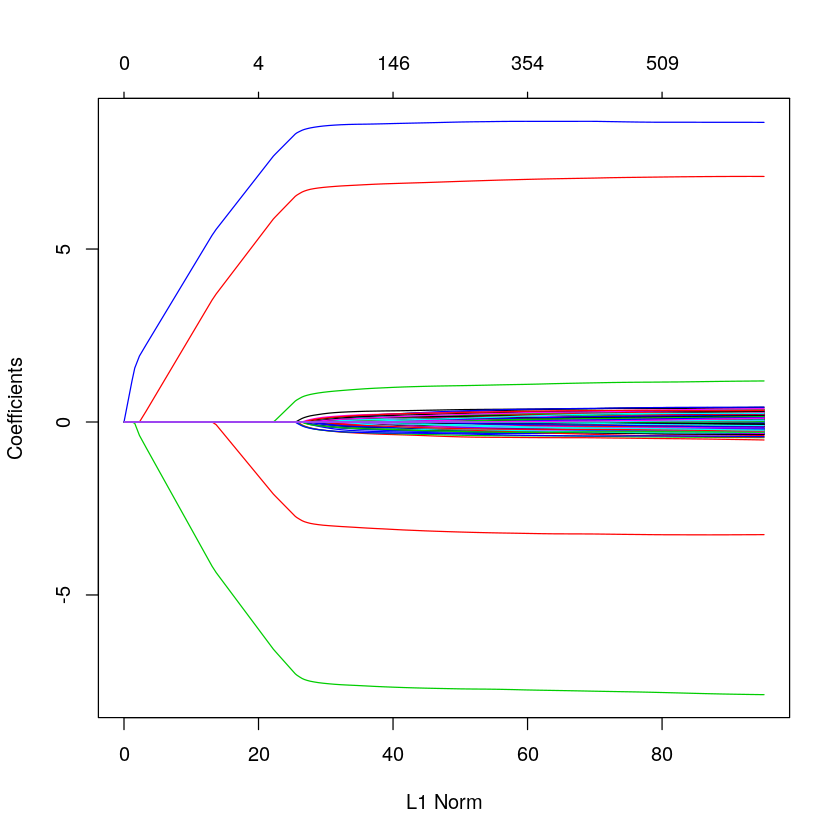

In [41]:
plot(fit)

So we have to take just 5 variables

In [33]:
tmp_coeffs <- coef(fit, s = fit$lambda[50])
data.frame(name = tmp_coeffs@Dimnames[[1]][tmp_coeffs@i + 1], coefficient = tmp_coeffs@x)

name,coefficient
(Intercept),16.2474851
x1623,8.2088786
x1764,6.4046415
x1028,0.4937093
x420,-7.1493013
x456,-2.6098243


In [37]:
CV(Y ~ 1 + x1623 + x1764 + x1028 + x420 + x456, data = protein.data.train, model=lm)

[1] 36.72422


In [145]:
model.protein.lm = lm(Y ~ 1 + x1623 + x1764 + x1028 + x420 + x456, data = protein.data.train,)

In [147]:
best.features.protein <- c("x1623","x1764","x1028","x420","x456")

##### XGBoost
Let's try now something different

In [115]:
model <- train(
  Y ~., data = protein.data.train[,c(best.features.protein,"Y")], method = "xgbTree",
  trControl = trainControl("cv", number = 10)
  )

In [135]:
dtrain <- xgb.DMatrix(data.matrix(protein.data.train[,best.features.protein]), label = protein.data.train[,"Y"])
cv <- xgb.cv(data = dtrain, nrounds = 100, nthread = 4, nfold = 5, metrics = list("rmse"),
                  max_depth = 4, eta = 0.2, lambda = 2, alpha=1, objective = "reg:linear")

[1]	train-rmse:18.794322+0.168125	test-rmse:18.989687+0.803819 
[2]	train-rmse:16.066806+0.120374	test-rmse:16.505774+0.684960 
[3]	train-rmse:13.907464+0.102198	test-rmse:14.654388+0.703796 
[4]	train-rmse:12.234256+0.116238	test-rmse:13.270582+0.704556 
[5]	train-rmse:10.914498+0.123643	test-rmse:12.237051+0.765119 
[6]	train-rmse:9.872320+0.130451	test-rmse:11.435853+0.871409 
[7]	train-rmse:9.044730+0.143736	test-rmse:10.851854+0.976836 
[8]	train-rmse:8.337310+0.136046	test-rmse:10.335507+1.113273 
[9]	train-rmse:7.783666+0.134492	test-rmse:9.930953+1.207358 
[10]	train-rmse:7.330367+0.109192	test-rmse:9.572031+1.282955 
[11]	train-rmse:6.947243+0.097803	test-rmse:9.237925+1.286784 
[12]	train-rmse:6.630570+0.077457	test-rmse:9.037792+1.243497 
[13]	train-rmse:6.350575+0.073733	test-rmse:8.788430+1.245075 
[14]	train-rmse:6.130731+0.054878	test-rmse:8.594039+1.233636 
[15]	train-rmse:5.935820+0.043261	test-rmse:8.493125+1.276142 
[16]	train-rmse:5.768157+0.054281	test-rmse:8.38266

As we see, XGBoost may performs well on train data, but overfits fatally on test set 

#### Cancer data

##### Linear regression with lasso

In [159]:
fit = cv.glmnet(data.matrix(cancer.data.train[, !names(cancer.data.train) %in% c("Y")]), cancer.data.train$Y, alpha = 1)

In [186]:
small.lambda.index <- which(fit$lambda == fit$lambda.min)

In [194]:
tmp_coeffs <- coef(fit, s = fit$lambda[small.lambda.index])
selected.features <- tmp_coeffs@Dimnames[[1]][tmp_coeffs@i + 1][-1]

In [195]:
CV(paste("Y ~ 1 + ",selected.features,sep = ""), data =  cancer.data.train, model=lm)

[1] 0.03315922


##### PCR with linear regression

##### XGBoost

In [210]:
dtrain <- xgb.DMatrix(data.matrix(cancer.data.train[, !names(cancer.data.train) %in% c("Y")]), label = cancer.data.train[,"Y"])
x <- xgb.importance(model = xgboost(data = dtrain, nrounds = 100, nthread = 4, nfold = 5, metrics = list("rmse"),
                  max_depth = 5, eta = 0.2, lambda = 2, alpha=1, objective = "reg:linear"))

[1]	train-rmse:0.296343 
[2]	train-rmse:0.247918 
[3]	train-rmse:0.209511 
[4]	train-rmse:0.178922 
[5]	train-rmse:0.153549 
[6]	train-rmse:0.134065 
[7]	train-rmse:0.117401 
[8]	train-rmse:0.104807 
[9]	train-rmse:0.093778 
[10]	train-rmse:0.085120 
[11]	train-rmse:0.078758 
[12]	train-rmse:0.072711 
[13]	train-rmse:0.068180 
[14]	train-rmse:0.064158 
[15]	train-rmse:0.060501 
[16]	train-rmse:0.057103 
[17]	train-rmse:0.054107 
[18]	train-rmse:0.051496 
[19]	train-rmse:0.048939 
[20]	train-rmse:0.046724 
[21]	train-rmse:0.044850 
[22]	train-rmse:0.042987 
[23]	train-rmse:0.041353 
[24]	train-rmse:0.040044 
[25]	train-rmse:0.038507 
[26]	train-rmse:0.037220 
[27]	train-rmse:0.036082 
[28]	train-rmse:0.034912 
[29]	train-rmse:0.033821 
[30]	train-rmse:0.032815 
[31]	train-rmse:0.031896 
[32]	train-rmse:0.031080 
[33]	train-rmse:0.030207 
[34]	train-rmse:0.029579 
[35]	train-rmse:0.028747 
[36]	train-rmse:0.028138 
[37]	train-rmse:0.027528 
[38]	train-rmse:0.026901 
[39]	train-rmse:0.026

In [252]:
selected.features.for.xgboost <- x[order(Gain, decreasing = T),] [1:110,]$Feature

In [253]:
dtrain <- xgb.DMatrix(data.matrix(cancer.data.train[, selected.features.for.xgboost]), label = cancer.data.train[,"Y"])
cv <- xgb.cv(data = dtrain, nrounds = 100, nthread = 4, nfold = 5, metrics = list("rmse"),
                  max_depth = 4, eta = 0.2, lambda = 2, alpha=1, objective = "reg:linear", gamma=0.1)

[1]	train-rmse:0.298477+0.001881	test-rmse:0.301652+0.008873 
[2]	train-rmse:0.252106+0.001871	test-rmse:0.260532+0.009503 
[3]	train-rmse:0.215527+0.001566	test-rmse:0.227344+0.008394 
[4]	train-rmse:0.186439+0.001616	test-rmse:0.202953+0.006911 
[5]	train-rmse:0.163576+0.001258	test-rmse:0.184932+0.006643 
[6]	train-rmse:0.145497+0.001231	test-rmse:0.171346+0.007312 
[7]	train-rmse:0.131111+0.000669	test-rmse:0.160073+0.006992 
[8]	train-rmse:0.120332+0.001806	test-rmse:0.151891+0.005946 
[9]	train-rmse:0.112391+0.001221	test-rmse:0.146746+0.005339 
[10]	train-rmse:0.106225+0.001520	test-rmse:0.142315+0.005076 
[11]	train-rmse:0.101604+0.001966	test-rmse:0.140158+0.004981 
[12]	train-rmse:0.098602+0.001618	test-rmse:0.138446+0.005513 
[13]	train-rmse:0.095307+0.001380	test-rmse:0.137443+0.005586 
[14]	train-rmse:0.093233+0.001378	test-rmse:0.135949+0.005723 
[15]	train-rmse:0.091504+0.001430	test-rmse:0.134950+0.005769 
[16]	train-rmse:0.091021+0.001205	test-rmse:0.134506+0.005906 
[

### Analyzing most important variables

#### Protein

##### Vif

#### Cancer

##### Vif

### Saving data

In [ ]:
stepAIC(lm(Y ~ 1, data = protein.data.train), direction = "forward", scope=list(upper=lm(Y ~ ., data = protein.data.train),lower=lm(Y ~ 1, data = protein.data.train)), trace = 2)

In [ ]:
stepAIC(lm(Y ~ 1, data = protein.data.train), direction = "forward", scope=list(upper=lm(Y ~ ., data = protein.data.train),lower=lm(Y ~ 1, data = protein.data.train)), trace = 2, k=log(nrow(protein.data.train)))

In [ ]:
model = lm(Y ~ x1623 + x420 + x1764 + x456 + x1028 + x1868 + x1756 + x1104 + 
    x410 + x1064 + x223 + x289 + x1027 + x497 + x1894 + x676 + 
    x1200 + x686 + x1316 + x1789 + x1934 + x1559 + x1683 + x996 + 
    x1418 + x1102 + x1109 + x1745 + x1946 + x148 + x843 + x928 + 
    x457 + x1860 + x1019 + x1443 + x1536 + x458 + x1979 + x737 + 
    x212 + x1943 + x1219 + x535 + x91, data = protein.data.train)

In [ ]:
summary(model)

In [ ]:
vif(lm(Y ~ ., data = protein.data.train))

In [ ]:
x <- alias(lm(Y ~ ., data = protein.data.train))

In [ ]:
typeof(x$Complete)

In [ ]:
x.complete <- x$Complete

In [ ]:
?alias

In [ ]:
sort(rownames(x.complete))

In [ ]:
sort(colnames(x.complete))

In [ ]:
length(intersect(colnames(protein.data.train),rownames(x.complete)))

In [ ]:
length(rownames(x.complete))

In [ ]:
? cast

In [ ]:
? stepAIC

In [89]:
?lightgbm